In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd drive/MyDrive/UNI-AMRITA-SEM4/densedrive/

/content/drive/MyDrive/UNI-AMRITA-SEM4/densedrive


In [3]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import torch
from lib.efficientmtl import EfficientMTL
#from pthflops import count_ops


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Specify a path
PATH = "models/efficientmtl_weights.pt"

# Load
model = torch.load(PATH, map_location=torch.device('cpu'))
model.eval()

EfficientMTL(
  (backbone): FeatureListNet(
    (stem_0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (stem_1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    (stages_0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (fc2): Linear(in_features=384, out_features=96, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (norm): LayerNorm((96,), eps=1e-06, elementwise_affin

In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

In [5]:
count_parameters(model) #4.4M

37138221

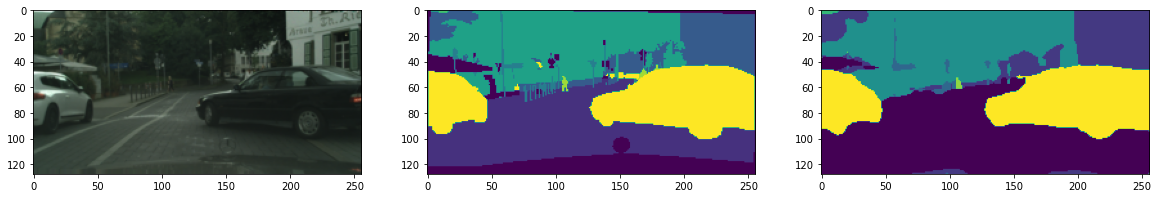

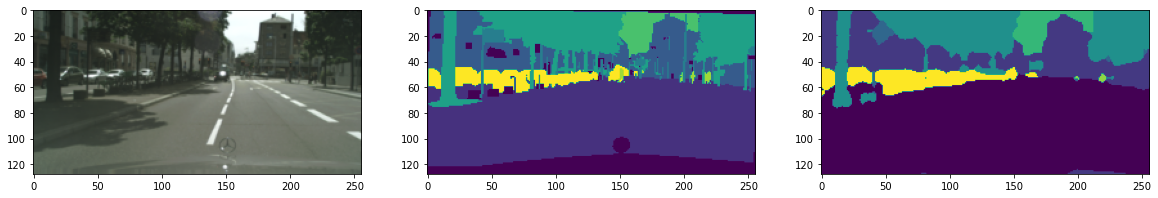

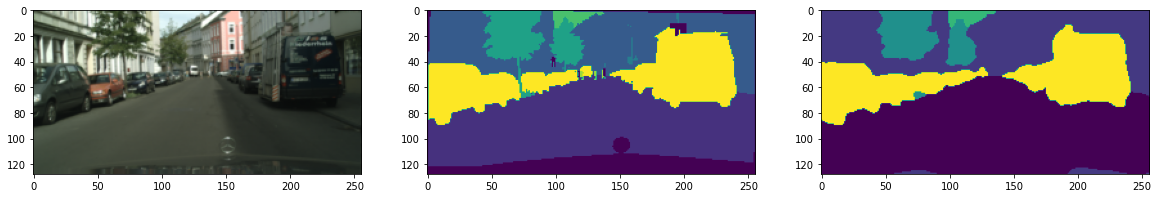

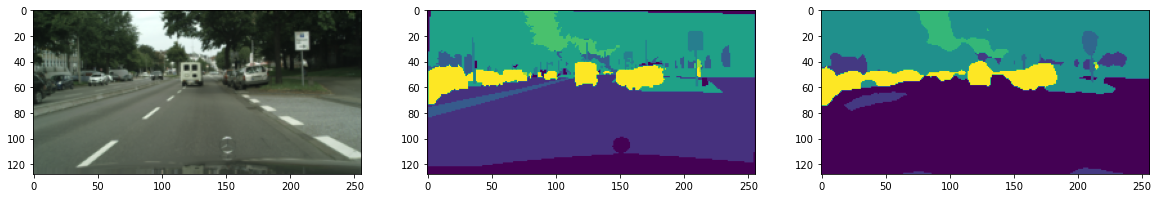

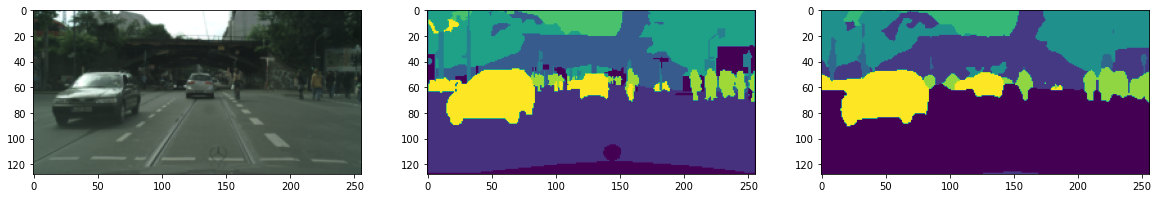

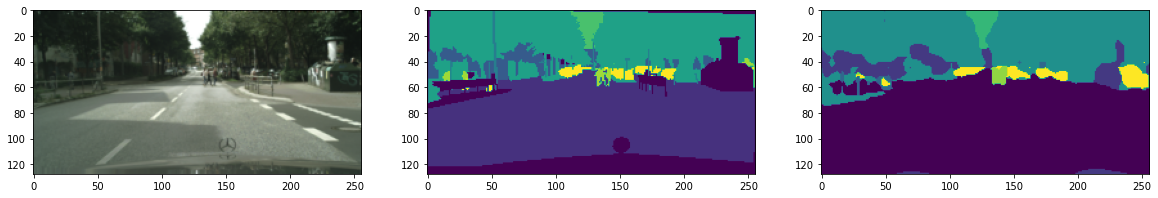

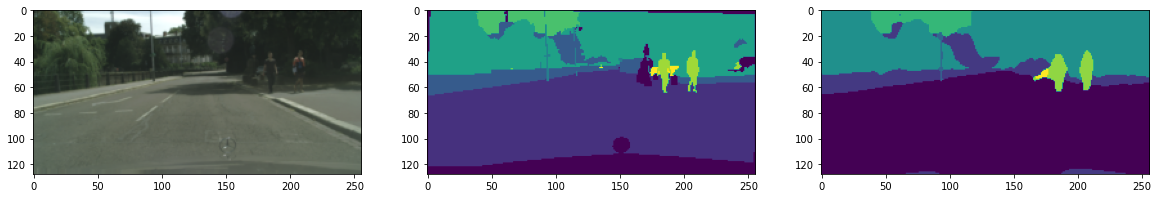

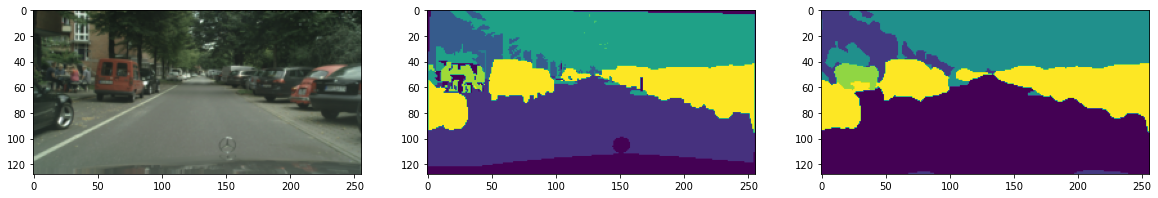

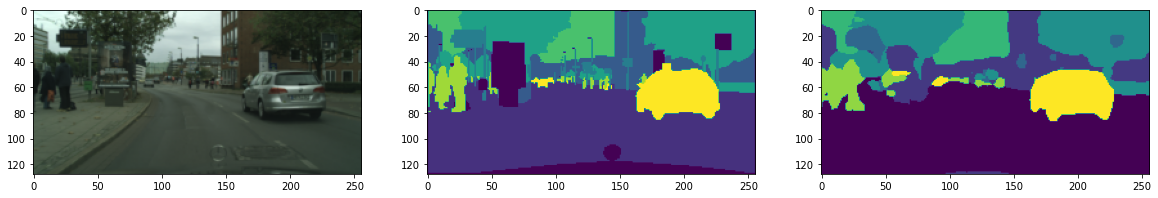

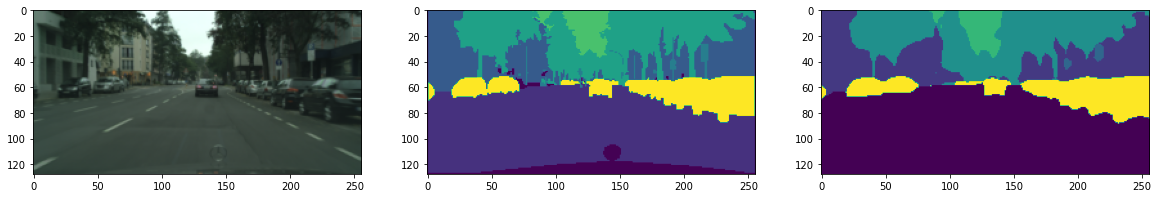

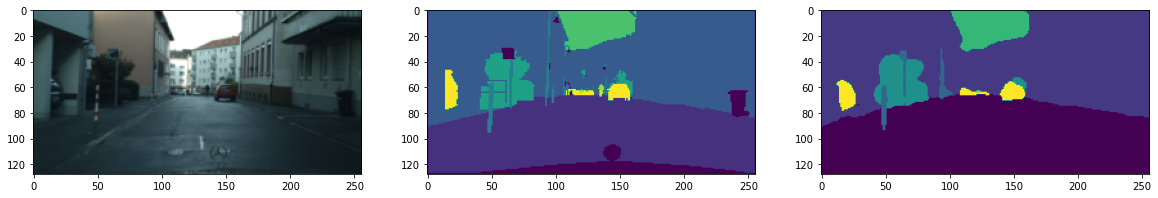

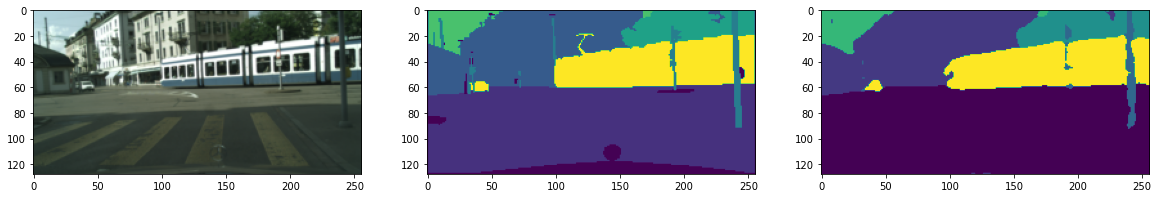

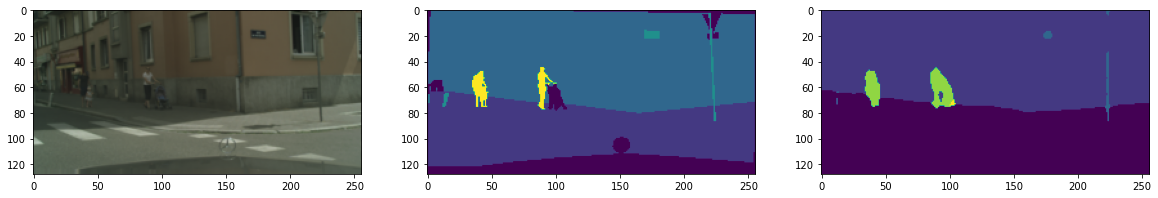

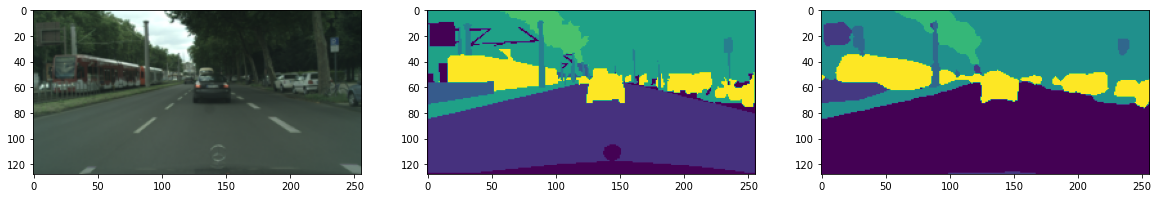

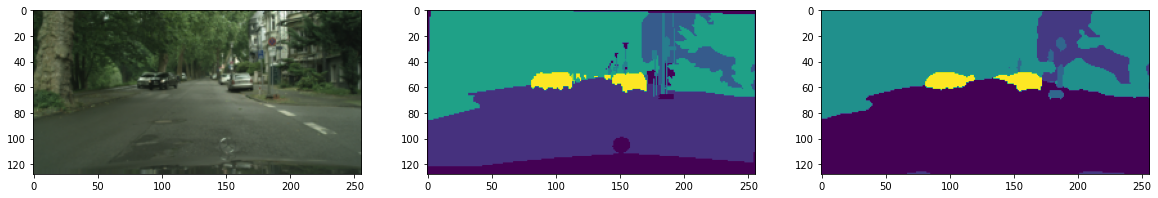

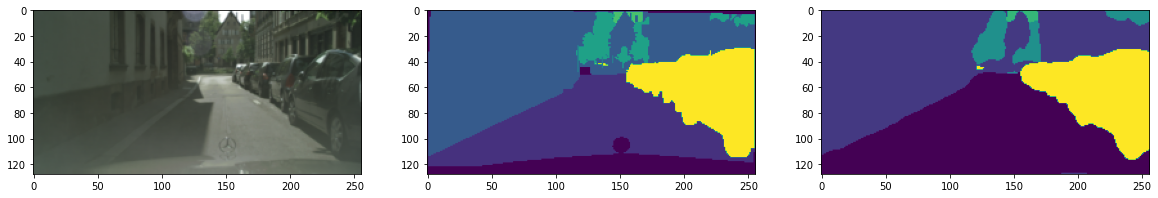

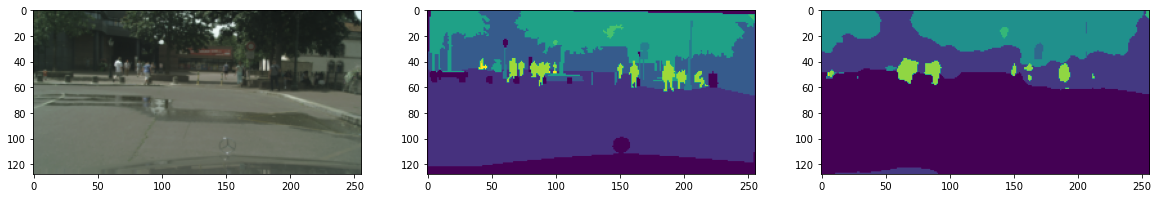

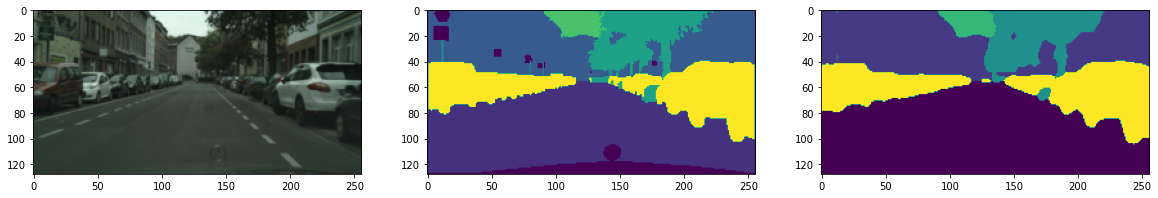

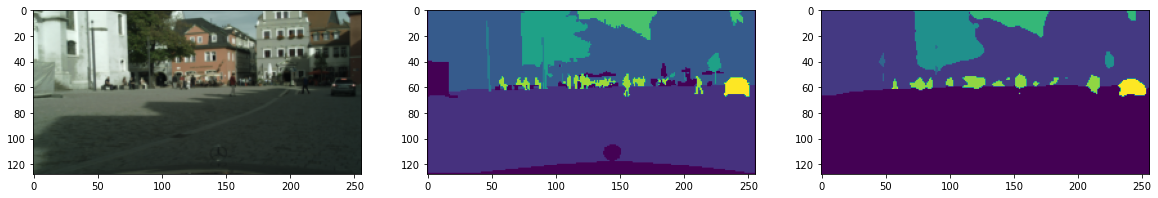

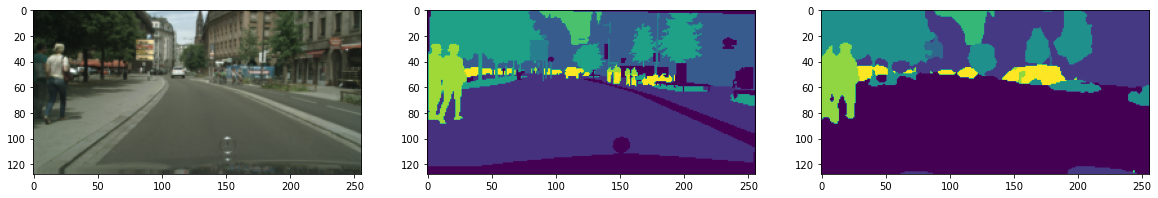

In [13]:
import os
import random 
import numpy as np
from lib.efficientmtl import EfficientMTL
import matplotlib.pyplot as plt

VALID_DIR = 'cityscapes_processed/train/'
n_files = 20
files = random.sample(os.listdir(VALID_DIR + 'image'), n_files)
segmentations = []
depths = []
images_p = []

for file in files:
    img = torch.from_numpy(np.expand_dims(np.moveaxis(np.load(VALID_DIR + 'image/' + file), -1, 0), axis = 0))
    img = img.to(device)
    seg_prediction, depth_prediction,_ = model(img.float())
    
    image_p = img.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
    seg_prediction = np.moveaxis(seg_prediction.cpu().detach().numpy(), 0, -1).argmax(0)
    depth_prediction = np.moveaxis(depth_prediction.cpu().detach().numpy(), 0, -1).squeeze(0)
    #print(image_p.shape, seg_prediction.shape, depth_prediction.shape)
    
    segmentations.append(seg_prediction)
    depths.append(depth_prediction)
    images_p.append(image_p)
    
for file, image, seg_pred, depth_pred in zip(files, images_p, segmentations,depths):
    seg_label = np.load(VALID_DIR + 'label/' + file)
    
    plt.figure(figsize = (20,10))
    plt.subplot(1, 3, 1)
    plt.imshow(image)

    plt.subplot(1, 3, 2)
    plt.imshow(seg_label)

    plt.subplot(1, 3, 3)
    plt.imshow(seg_pred)

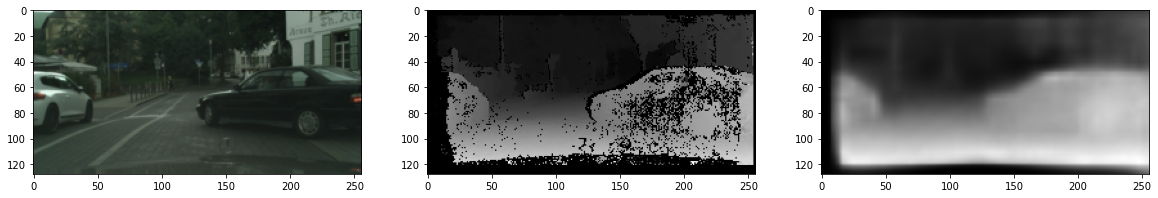

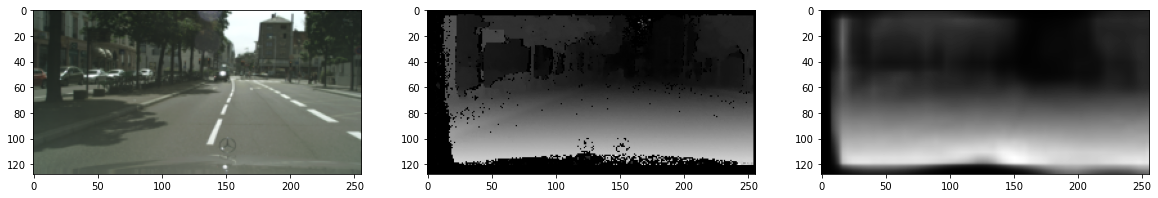

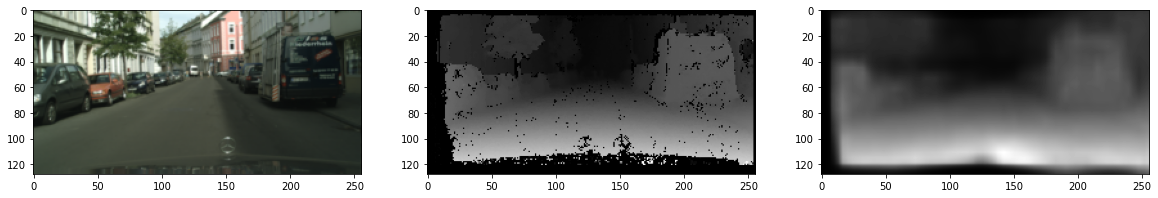

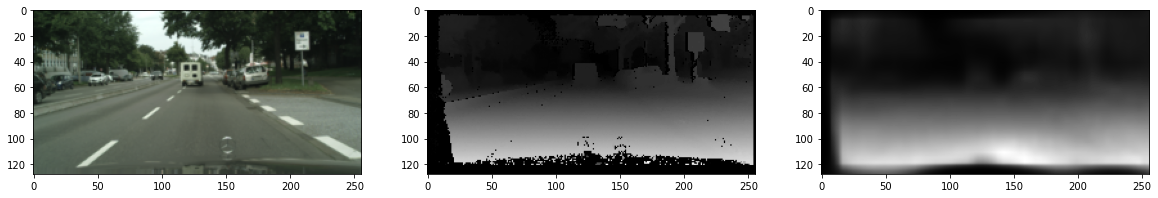

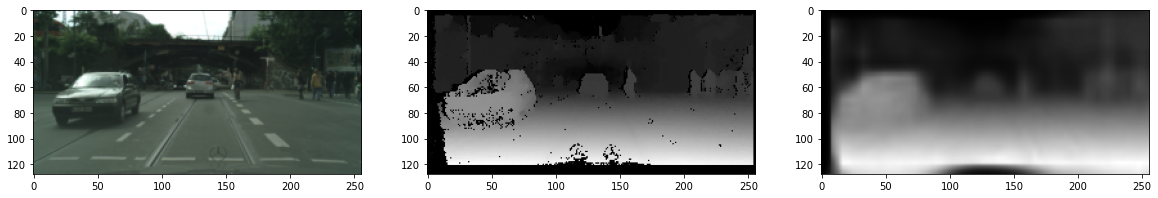

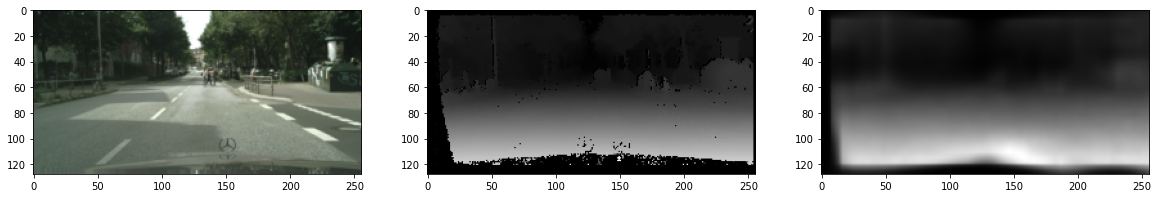

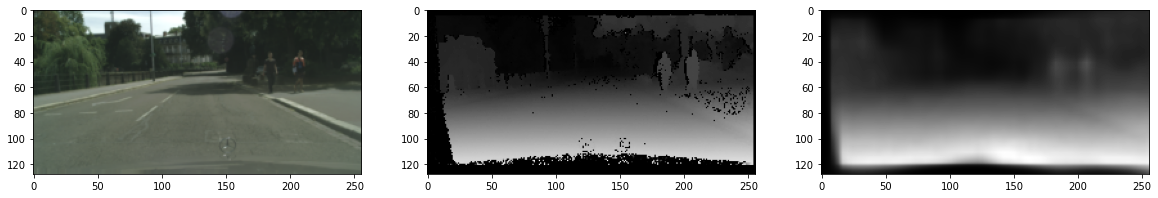

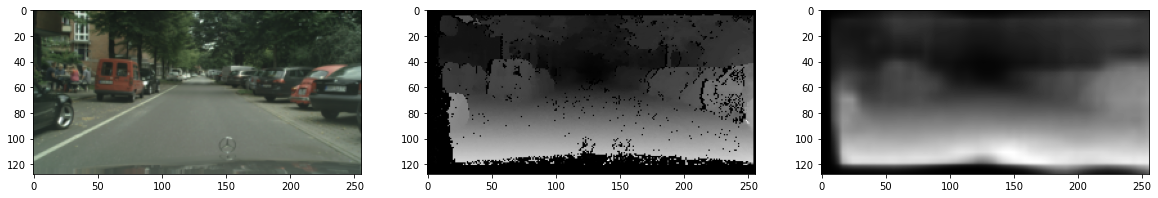

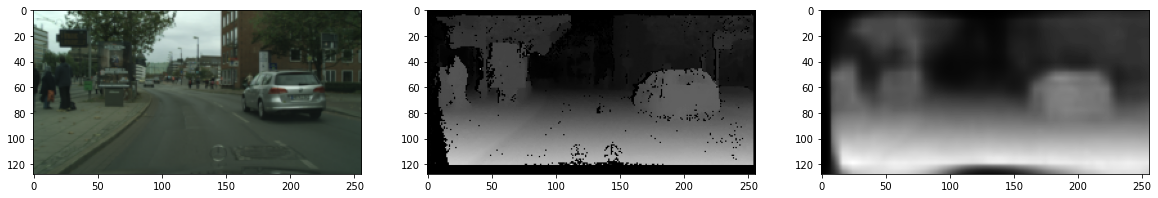

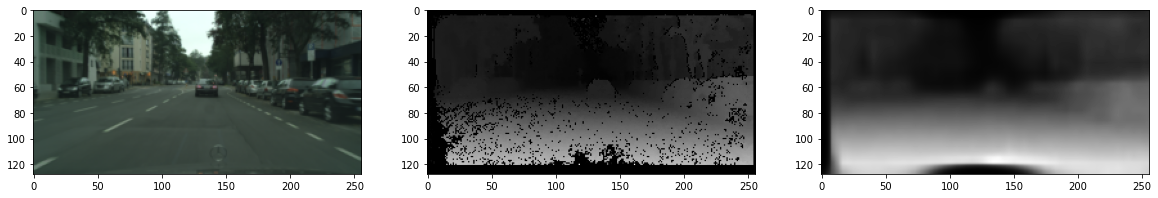

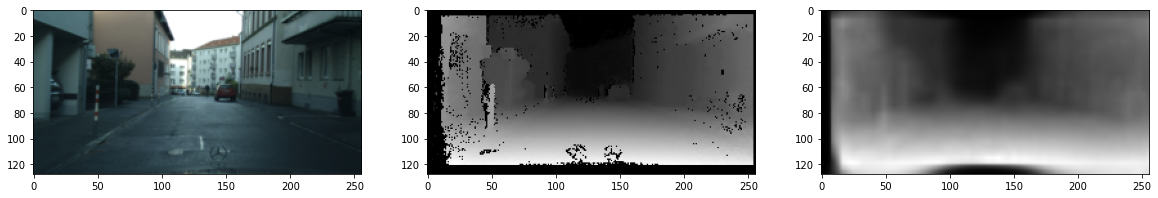

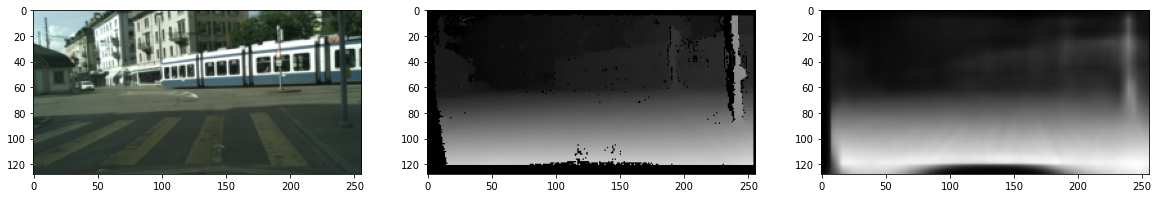

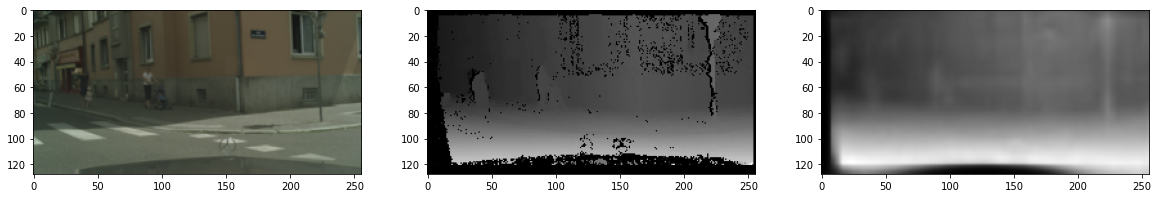

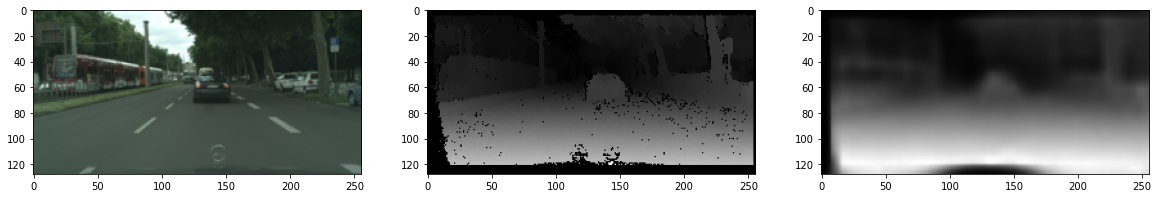

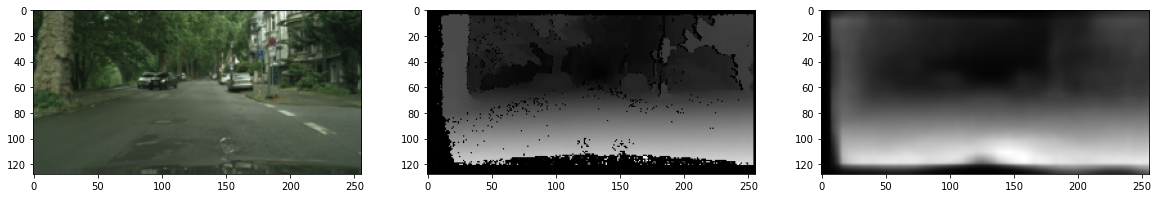

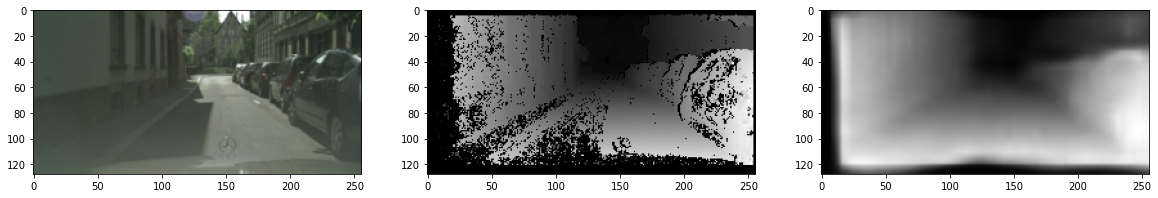

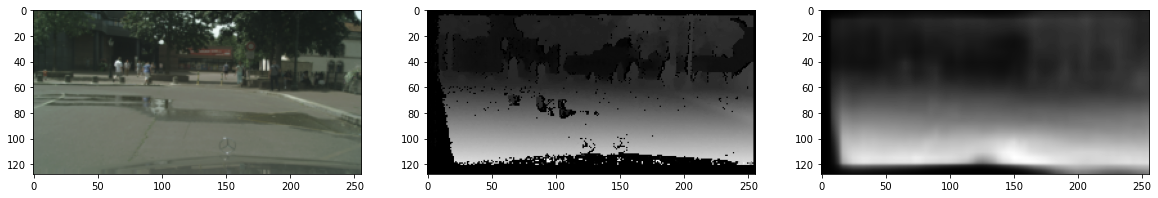

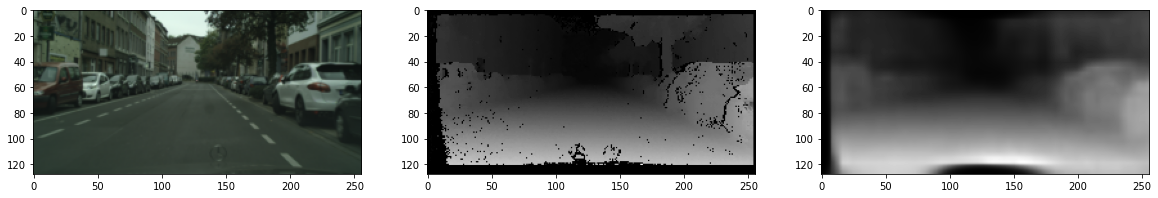

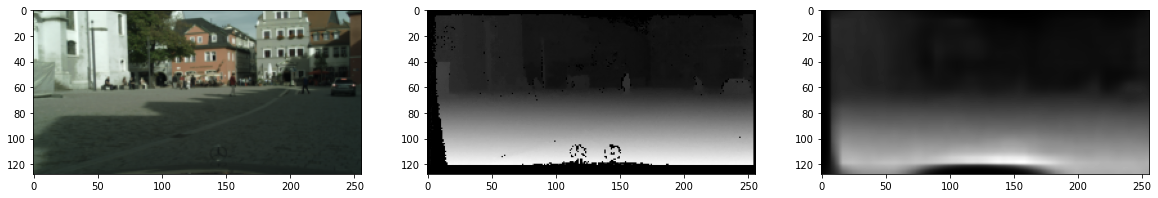

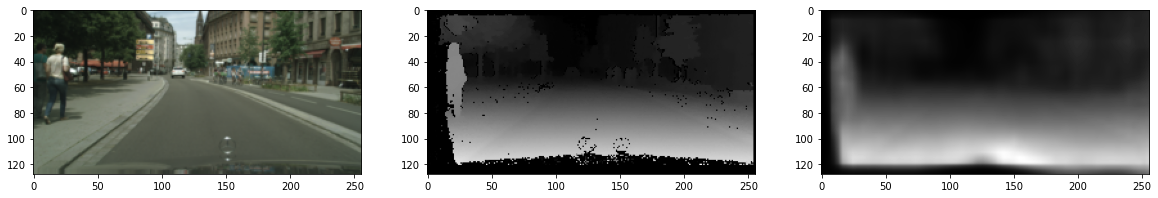

In [14]:
for file, image, seg_pred, depth_pred in zip(files, images_p, segmentations,depths):
    depth_label = np.load(VALID_DIR + 'depth/' + file)
    
    plt.figure(figsize = (20,10))
    plt.subplot(1, 3, 1)
    plt.imshow(image)

    plt.subplot(1, 3, 2)
    plt.imshow(depth_label, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.imshow(depth_pred, cmap='gray')